In [1]:
#importing libraries
import xarray as xr
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [2]:
# Load dataset
ds = xr.open_dataset("cru_ts4.07.1901.2022.pre.dat.nc")
ds

<xarray.Dataset>
Dimensions:  (lon: 720, lat: 360, time: 1464)
Coordinates:
  * lon      (lon) float32 -179.8 -179.2 -178.8 -178.2 ... 178.8 179.2 179.8
  * lat      (lat) float32 -89.75 -89.25 -88.75 -88.25 ... 88.75 89.25 89.75
  * time     (time) datetime64[ns] 1901-01-16 1901-02-15 ... 2022-12-16
Data variables:
    pre      (time, lat, lon) float32 ...
    stn      (time, lat, lon) float64 ...
Attributes:
    Conventions:  CF-1.4
    title:        CRU TS4.07 Precipitation
    institution:  Data held at British Atmospheric Data Centre, RAL, UK.
    source:       Run ID = 2304141047. Data generated from:pre.2304141039.dtb
    history:      Fri 14 Apr 12:49:03 BST 2023 : User f098 : Program makegrid...
    references:   Information on the data is available at http://badc.nerc.ac...
    comment:      Access to these data is available to any registered CEDA user.
    contact:      support@ceda.ac.uk

In [3]:
#checking time coordinates
print("Time coordinate:", ds.coords.get('time'))
print("Time values:", ds.time.values)

Time coordinate: <xarray.DataArray 'time' (time: 1464)>
array(['1901-01-16T00:00:00.000000000', '1901-02-15T00:00:00.000000000',
       '1901-03-16T00:00:00.000000000', ..., '2022-10-16T00:00:00.000000000',
       '2022-11-16T00:00:00.000000000', '2022-12-16T00:00:00.000000000'],
      dtype='datetime64[ns]')
Coordinates:
  * time     (time) datetime64[ns] 1901-01-16 1901-02-15 ... 2022-12-16
Attributes:
    long_name:  time
Time values: ['1901-01-16T00:00:00.000000000' '1901-02-15T00:00:00.000000000'
 '1901-03-16T00:00:00.000000000' ... '2022-10-16T00:00:00.000000000'
 '2022-11-16T00:00:00.000000000' '2022-12-16T00:00:00.000000000']


In [4]:
# time sorting
ds = ds.sortby('time')

# Slice time from 1990 to 2020 inclusive
ds = ds.sel(time=slice('1990-01-01', '2020-12-31'))

In [5]:
# Liberia bounding box
min_lat, max_lat = 4.0, 8.5
min_lon, max_lon = -11.5, -7.0

# Subset the dataset
subset = ds.sel(lat=slice(min_lat, max_lat), lon=slice(min_lon, max_lon))

In [6]:
print(subset.dims)
print(subset['pre'])

Frozen({'lon': 9, 'lat': 9, 'time': 372})
<xarray.DataArray 'pre' (time: 372, lat: 9, lon: 9)>
[30132 values with dtype=float32]
Coordinates:
  * lon      (lon) float32 -11.25 -10.75 -10.25 -9.75 ... -8.25 -7.75 -7.25
  * lat      (lat) float32 4.25 4.75 5.25 5.75 6.25 6.75 7.25 7.75 8.25
  * time     (time) datetime64[ns] 1990-01-16 1990-02-15 ... 2020-12-16
Attributes:
    long_name:                   precipitation
    units:                       mm/month
    correlation_decay_distance:  450.0


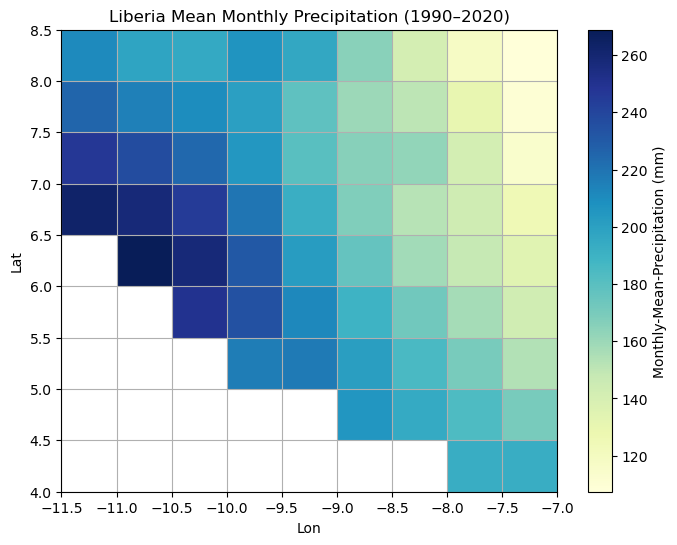

In [7]:
# Mean precipitation over time
mean_precip = subset['pre'].mean(dim='time')

# Plot
plt.figure(figsize=(8, 6))
mean_precip.plot(cmap='YlGnBu', cbar_kwargs={'label': 'Monthly-Mean-Precipitation (mm)'})
plt.title('Liberia Mean Monthly Precipitation (1990–2020)')
plt.xlabel('Lon')
plt.ylabel('Lat')
plt.grid(True)
plt.show()

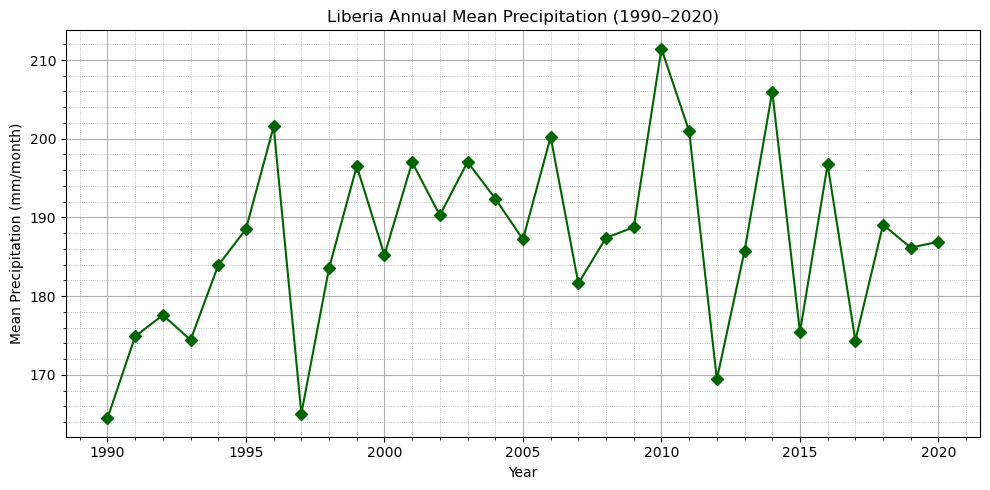

In [8]:
# 1. Average across space (Liberia bounding box) to get monthly national average
monthly_mean = subset['pre'].mean(dim=['lat', 'lon'])

# 2. Convert to pandas for resampling
df = monthly_mean.to_dataframe().dropna()
df.index = pd.to_datetime(df.index)  # ensure time index is datetime

# 3. Resample monthly to annual mean
annual_mean = df['pre'].resample('Y').mean()

# 4. Plot as line graph
plt.figure(figsize=(10, 5))
plt.plot(annual_mean.index.year, annual_mean.values, marker='D', linestyle='-',color='darkgreen')
plt.title('Liberia Annual Mean Precipitation (1990–2020)')
plt.xlabel('Year')
plt.ylabel('Mean Precipitation (mm/month)')
plt.grid(True)
plt.minorticks_on()
plt.grid(True, which='minor', linestyle=':', linewidth=0.6)
plt.tight_layout()
plt.show()

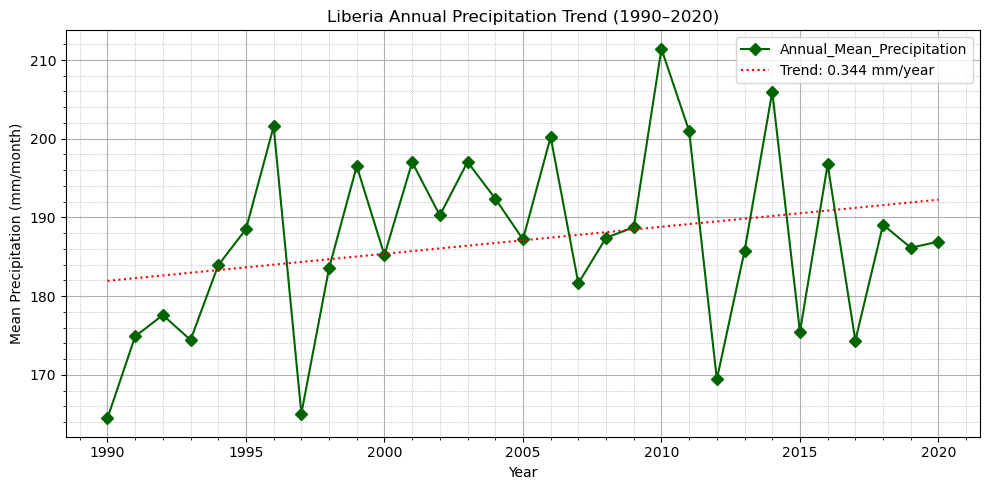

Precipitation is increasing at approximately 0.344 mm/year.


In [9]:
# Extract (years) and (annual mean precipitation values)
years = annual_mean.index.year.values
precip = annual_mean.values

# Fit a linear regression line: y = m*x + b
slope, intercept = np.polyfit(years, precip, 1)
trend_line = slope * years + intercept

# Plot the time series and trend
plt.figure(figsize=(10, 5))
plt.plot(years, precip, marker='D',color='darkgreen', label='Annual_Mean_Precipitation')
plt.plot(years, trend_line, color='Red', linestyle=':', label=f'Trend: {slope:.3f} mm/year')
plt.title('Liberia Annual Precipitation Trend (1990–2020)')
plt.xlabel('Year')
plt.ylabel('Mean Precipitation (mm/month)')
plt.grid(True)
plt.minorticks_on()
plt.grid(True, which='minor', linestyle=':', linewidth=0.6) 
plt.legend()
plt.tight_layout()
plt.show()

# Print interpretation
if slope > 0:
    print(f"Precipitation is increasing at approximately {slope:.3f} mm/year.")
elif slope < 0:
    print(f"Precipitation is decreasing at approximately {abs(slope):.3f} mm/year.")
else:
    print("No significant trend in precipitation.")

In [10]:
# Compute standard deviation( VARIABILITY ANALYSIS)
std_dev = np.std(precip)
print(f"Standard Deviation of Annual Mean Precipitation: {std_dev:.3f} mm/month")

Standard Deviation of Annual Mean Precipitation: 11.374 mm/month


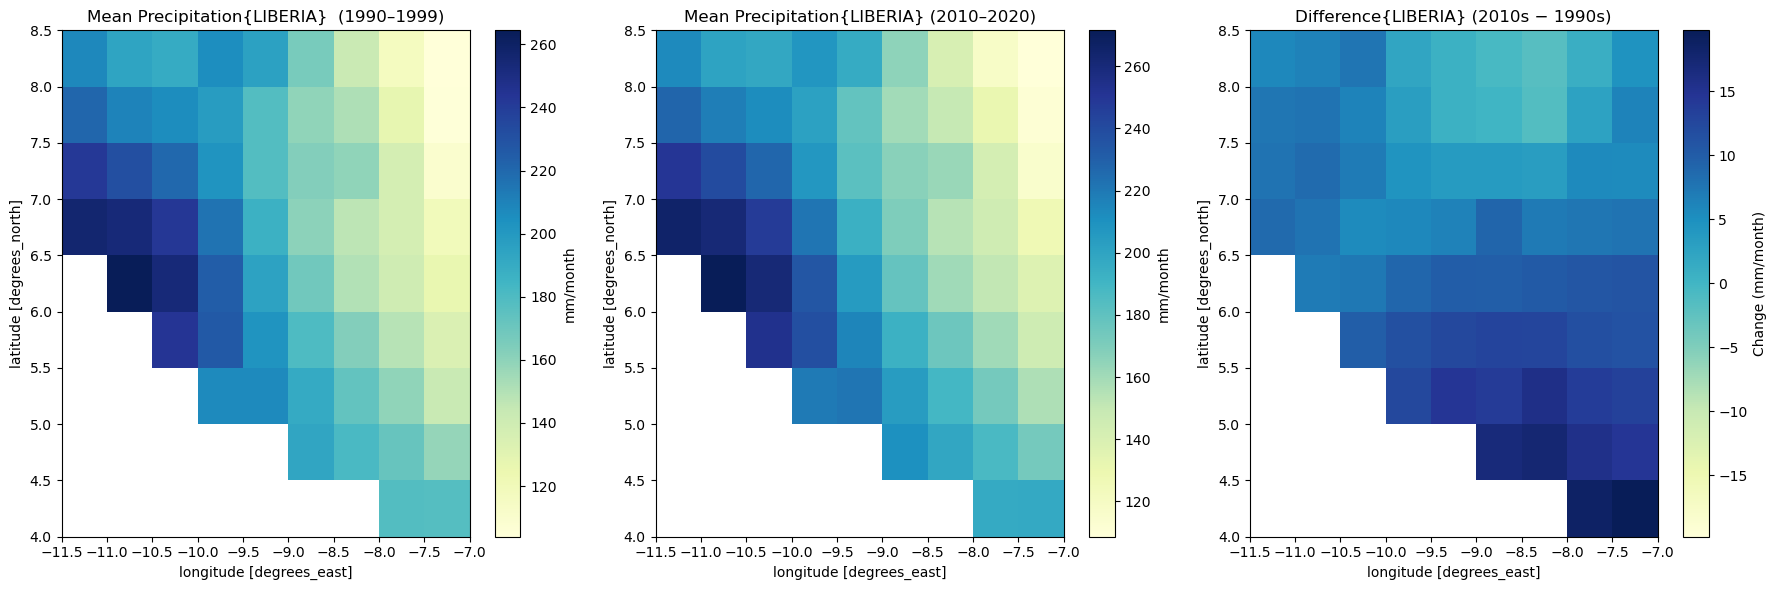

In [11]:
# Step 1: Slice each decade
subset_1990s = subset.sel(time=slice('1990-01-01', '1999-12-31'))
subset_2010s = subset.sel(time=slice('2010-01-01', '2020-12-31'))

# Step 2: Compute decadal means (spatial grid, time-averaged)
mean_1990s = subset_1990s['pre'].mean(dim='time')
mean_2010s = subset_2010s['pre'].mean(dim='time')

# Step 3: Compute the difference (recent decade - early decade)
diff = mean_2010s - mean_1990s

# Step 4: Plot all 3 maps
fig, axs = plt.subplots(1, 3, figsize=(18, 6))

# 1990s
mean_1990s.plot(ax=axs[0], cmap='YlGnBu', cbar_kwargs={'label': 'mm/month'})
axs[0].set_title('Mean Precipitation{LIBERIA}  (1990–1999)')

# 2010s
mean_2010s.plot(ax=axs[1], cmap='YlGnBu', cbar_kwargs={'label': 'mm/month'})
axs[1].set_title('Mean Precipitation{LIBERIA} (2010–2020)')

# Difference
diff.plot(ax=axs[2], cmap='YlGnBu', cbar_kwargs={'label': 'Change (mm/month)'})
axs[2].set_title('Difference{LIBERIA} (2010s − 1990s)')

plt.tight_layout()
plt.show()

In [12]:
# Step 1: Flatten the difference array into a DataFrame
diff_vals = diff.values.flatten()
lats, lons = np.meshgrid(diff['lat'].values, diff['lon'].values, indexing='ij')

# Flatten lat/lon to match the diff values
lat_flat = lats.flatten()
lon_flat = lons.flatten()

# Combine into a DataFrame
hotspot_df = pd.DataFrame({'Latitude': lat_flat,'Longitude': lon_flat,'Change (mm/month)': diff_vals})

# Step 2: Sort and get top 5 increases and decreases
top_increases = hotspot_df.sort_values(by='Change (mm/month)', ascending=False).head(5)
top_decreases = hotspot_df.sort_values(by='Change (mm/month)', ascending=True).head(5)

# Display results
print("Top 5 Grid Points with Largest Increases:")
print(top_increases)

print("\nTop 5 Grid Points with Largest Decreases:")
print(top_decreases)

Top 5 Grid Points with Largest Increases:
    Latitude  Longitude  Change (mm/month)
8       4.25      -7.25          19.777084
7       4.25      -7.75          18.628464
15      4.75      -8.25          17.532654
14      4.75      -8.75          16.931915
24      5.25      -8.25          15.860870

Top 5 Grid Points with Largest Decreases:
    Latitude  Longitude  Change (mm/month)
78      8.25      -8.25          -1.819855
69      7.75      -8.25          -1.512238
77      8.25      -8.75          -0.553940
68      7.75      -8.75           0.113602
76      8.25      -9.25           0.641754


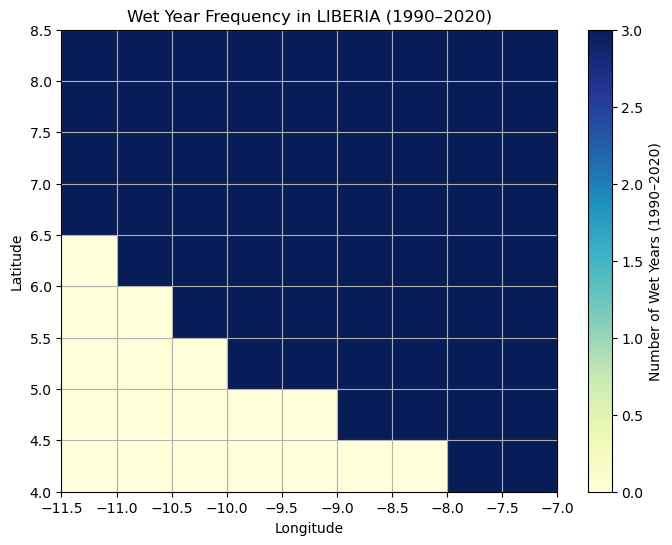

In [14]:
# Step 1: Group by year and compute annual mean per grid cell
annual_precip = subset['pre'].groupby('time.year').mean(dim='time')

# Step 2: Compute the 90th percentile threshold for each grid point
threshold = annual_precip.quantile(0.9, dim='year')

# Step 3: Identify "wet years" (True/False mask)
wet_years = annual_precip > threshold

# Step 4: Count number of wet years at each grid cell
wet_year_count = wet_years.sum(dim='year')

# Step 5: Plot the wet year frequency map
plt.figure(figsize=(8, 6))
wet_year_count.plot(cmap='YlGnBu',cbar_kwargs={'label': 'Number of Wet Years (1990–2020)'})
plt.title('Wet Year Frequency in LIBERIA (1990–2020)')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.grid(True)
#clearing all warnings
import warnings
warnings.filterwarnings("ignore", message="All-NaN slice encountered")
plt.show()